In [224]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter # to format yaxis ticks

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
sys.path.append('F:/Users/yasam/Documents/GitHub/simgraph/code/my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import dataprocess.my_first_feature_extractor as fe

# Coordinates of keypoints

We need an affine matrix that converts the image-coordinates ({i, j, k} centered at the top-left corner of the oldest frame)
<br>
to the scanner-coordinates used by Nifti package ({x, y, z} centered at the bottom-left corner of the oldest frame).
<br>
For an explanation of these coordinates, please refer to https://nipy.org/nibabel/coordinate_systems.html#voxel-coordinates-and-points-in-space
<br>
<img src="file/Nifti affine matrix.png" width="300">

Hopefully, Sift3D also uses Nifti scanner coordinates; therefore, location of keypoints are described in those coordinates.

In [2]:
# The desired affine matrix
affine = np.array([[1, 0, 0, 0],
                   [0, -1, 0, 120],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
# sample_nifti = nib.Nifti1Image(sample_batched, affine=affine)

## Descriptor format:
[x, y, z, el0, el1, ..., el767]
<br>
Each row is a single feature descriptor. 
<br>
[x, y, z] are the keypoint's coordinates in 3D-image space, and [el0, el1, ..., el767] are the 768 dimensions of the descriptor.

## Keypoint format:
<br>
Each row is a keypoint. The elements of each row are as follows:
<br>
[x, y, z, o, s, $ori_{11}, ori_{12}, ..., ori_{nn}$]
<br>
x - the x-coordinate
<br>
y - the y-coordinate
<br>
z - the z-coordinate
<br>
o - the pyramid octave. To convert to image coordinates, multiply x,y,z by pow(2, o)
<br>
s - the scale coordinate
<br>
$ori_{ij}$ - the ith row, jth column of the orientation matrix

In [4]:
# load the fish movie
data_path = '../../../local_data/original_files/'

frames = np.loadtxt(data_path + 'frames.csv', delimiter=',')
frames = frames.reshape(frames.shape[0], 120, 200)
print('frames.shape = {}'.format(frames.shape))

frames.shape = (1141, 120, 200)


In [5]:
def show_random_frames(frames, nframes, seed=None):
    assert(len(frames) >= nframes)
    
    if seed is not None:
        np.random.seed(seed)
    
    plt.figure(figsize = (15, nframes))
    
    for i in range(nframes):
        ind = np.random.randint(0,len(frames))
        plt.subplot(-(nframes//-3),3,i+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

In [6]:
def show_consecutive_frames(frames, st_frame, nframes):
    assert(len(frames) >= nframes)
    
    plt.figure(figsize = (10, nframes//5))
    
    for ind in range(st_frame, st_frame+nframes):
        plt.subplot(-(nframes//-5),5,ind-st_frame+1)
        plt.imshow(frames[ind], cmap='gray')
        plt.axis("off")
        plt.axis("equal")

# show_consecutive_frames(frames, st_frame=100, nframes=10)
# show_random_frames(frames, nframes = 6, seed=0)

(-0.5, 199.5, 119.5, -0.5)

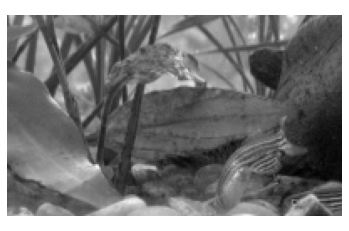

In [7]:
# draw one frame
ind = 150
plt.imshow(frames[ind], cmap='gray')
plt.axis("off")
plt.axis("equal")

In [8]:
xs = []
ys = []
zs = []

for batch_i in range(1141):
    # load the batches feature vector and keypoint
    desc = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/desc/fv_'+str(batch_i)+'.csv')
    key = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/keys/fv_'+str(batch_i)+'.csv')
    z,y,x,o,s = key[:5] 
    xs.append(x * (2**o))
    ys.append(y * (2**o))
    zs.append(z * (2**o))

print('min_x = {} \t avg_x = {} \t max_x = {}'.format(np.min(xs), np.mean(xs), np.max(xs)))
print('min_y = {} \t avg_y= {} \t max_y = {}'.format(np.min(ys), np.mean(ys), np.max(ys)))
print('min_z = {} \t avg_z = {} \t max_z = {}'.format(np.min(zs), np.mean(zs), np.max(zs)))

min_x = 20.0 	 avg_x = 124.96757230499561 	 max_x = 192.0
min_y = 4.0 	 avg_y= 61.5635407537248 	 max_y = 108.0
min_z = 4.0 	 avg_z = 14.46099912357581 	 max_z = 24.0


In [9]:
# consider a batch of frames
batch_i = 600

# load the batches feature vector and keypoint
desc = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/desc/fv_'+str(batch_i)+'.csv')
key = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/keys/fv_'+str(batch_i)+'.csv')
print('descriptor shape = ', desc.shape)
print('keypoint = \n', key)
z,y,x,o,s = key[:5]
x = x * (2**o)
y = y * (2**o)
z = z * (2**o)
# Note: It seems like we've got the z and x axes mixed up
# z -> x
# y -> y
# x -> z
ori = key[5:].reshape((3,3))

descriptor shape =  (768,)
keypoint = 
 [ 2.0000000e+00  6.0000000e+00  1.4000000e+01  2.0000000e+00
  1.0159367e+01  2.5646000e-02 -1.7599000e-02  9.9951600e-01
 -5.8924100e-01  8.0742500e-01  2.9336000e-02 -8.0755100e-01
 -5.8970800e-01  1.0337000e-02]


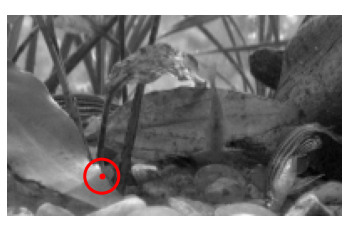

In [10]:
# draw the frame on which the keypoint resides
batch_sz = 32
frame_i = batch_i - batch_sz + 1 + int(z)
fig, ax = plt.subplots()
plt.imshow(frames[frame_i], cmap='gray')
plt.axis("off")
plt.axis("equal")

i = x
j = 120 - y
circle1 = plt.Circle((i,j), s, color='r', fill=False, linewidth=3)
ax.add_patch(circle1)
ax.plot((i), (j), 'o', color='r', markersize=5)

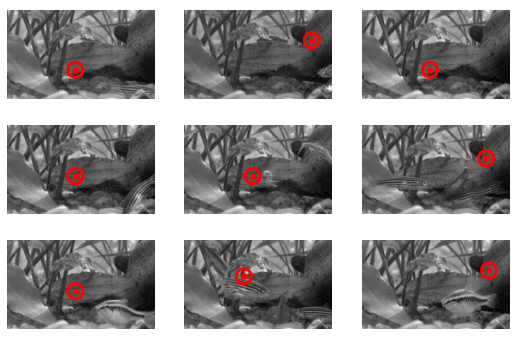

In [11]:
# draw keypoints for random batches of frames
nbatches = 9
plt.figure(figsize=(9,6))
for n in range(nbatches):
    batch_i = np.random.randint(0,len(frames))

    # load the batches feature vector and keypoint
    desc = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/desc/fv_'+str(batch_i)+'.csv')
    key = np.loadtxt('../../data/features/sift3d/fvs_s1_with_kp/keys/fv_'+str(batch_i)+'.csv')
    z,y,x,o,s = key[:5]
    x = x * (2**o)
    y = y * (2**o)
    z = z * (2**o)
    i = x
    j = 120 - y
    
    # draw the frame on which the keypoint resides
    frame_i = batch_i - batch_sz + 1 + int(z)
    ax = plt.subplot(int(np.ceil(nbatches/3)), 3, n+1)
    plt.imshow(frames[frame_i], cmap='gray')
    plt.axis("off")
    plt.axis("equal")
    circle1 = plt.Circle((i,j), s, color='r', fill=False, linewidth=3)
    ax.add_patch(circle1)
    ax.plot((i), (j), 'o', color='r', markersize=5)

# Find highly informative entries based on the optimized metric matrix

In [124]:
def visualize_M(M, large_x, large_y, mark_th, marker_color='r', save_name=None):
    plt.figure(figsize=(4,4))
    plt.imshow(M)
    plt.colorbar()        
    plt.plot(large_x, large_y, marker='o', markersize=3, color=marker_color, linestyle='')
    plt.title('M - marked above {}%'.format(mark_th))
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    plt.close()

Large entries x:  [247 277 247 270 270 247 277] 
Large entries y:  [247 247 277 270 247 270 277]
Large diagonal entries:  [247 270 277]


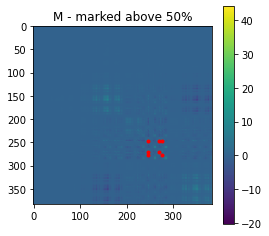

In [125]:
# choose an experiment whose results are going to be visualized
exp_path = '../../../local_data/experiments/sift3d/sift3d_sg/2023_07_14/'
# exp_path = '../../../local_data/experiments/sift3d/sift3d_sg/2023_10_17/'

# load an optimized metric matrix
M = np.load(exp_path + 'matrices/finalM_50_650_99.npy')
# M = np.load(exp_path + 'matrices/finalM_100_200_2.npy')

# parameters to visualize the optimized M
f_sz = 384 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
mark_th = 50

# find large entries
lim = (mark_th/100) * np.max(M)
large_x = xloc[M > lim]
large_y = yloc[M > lim]
# sort based on the M entry
large_x_sorted = np.array([x[0] for x in sorted(list(zip(large_x, M[M > lim])), key=lambda x: x[1], reverse=True)])
large_y_sorted = np.array([x[0] for x in sorted(list(zip(large_y, M[M > lim])), key=lambda x: x[1], reverse=True)])
print('Large entries x: ', large_x_sorted, '\nLarge entries y: ', large_y_sorted)
large_diag_sorted = large_x_sorted[large_x_sorted == large_y_sorted]
print('Large diagonal entries: ', large_diag_sorted)

# display the metric matrix
visualize_M(M, large_x_sorted, large_y_sorted, mark_th, marker_color='r', save_name='M.png')

In [126]:
# subsample the descriptor as it was during model training
desc_ss = desc[::2]
desc_ss.shape

(384,)

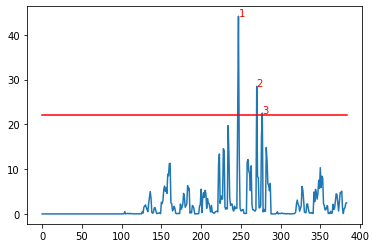

In [127]:
# draw digonal entries
Mdiag = np.diagonal(M)

plt.figure()
plt.plot(np.arange(f_sz), Mdiag)
plt.plot(np.arange(f_sz), lim*np.ones(f_sz), color='r')
i = 1
for ind in large_diag_sorted:
    # plt.text(ind, M[ind, ind], '({}, {:.2f})'.format(ind, M[ind, ind]), color='r')
    plt.text(ind, M[ind, ind], str(i), color='r')
    i += 1
plt.savefig('3dsift-Mdiag.png')
plt.show()

In [128]:
# find sub-regions and oreintations of features
orient_sorted = large_diag_sorted%6 #6 is used instead of 12 because the feature vectors are subsampled
region_x_sorted = large_diag_sorted//6%4
region_y_sorted = large_diag_sorted//6//4%4
region_z_sorted = large_diag_sorted//6//4//4
print('Highly informative features:\nreg_x: ', region_x_sorted, '\nreg_y: ', region_y_sorted, '\nreg_z: ', region_z_sorted, '\nOrientation: ', orient_sorted)

Highly informative features:
reg_x:  [1 1 2] 
reg_y:  [2 3 3] 
reg_z:  [2 2 2] 
Orientation:  [1 0 1]


## Compute median of features for all regions

In [129]:
# compute medians of features in all regions
meds = np.zeros(64)
for i in range(64):
    meds[i] = np.median(Mdiag[i*6:i*6+6])

Highest peaks of medians (index, peak):
 [[43.         10.15192036]
 [26.          8.70611937]
 [58.          7.75009416]
 [41.          7.18664555]]


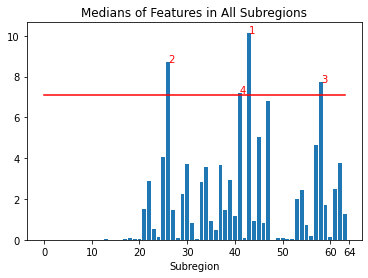

In [130]:
plt.figure()
plt.bar(np.arange(64), meds)
plt.title('Medians of Features in All Subregions')
plt.xlabel('Subregion')
_ = plt.xticks([0, 10, 20, 30, 40, 50, 60, 64])


# find highest peaks of medians
thresh = 0.7
plt.plot(np.arange(64), thresh*np.max(meds)*np.ones(64), color='r')
meds_sorted = np.array(sorted(list(zip(np.arange(64), meds)), key=lambda x: x[1], reverse=True))
peak_meds = meds_sorted[meds_sorted[:,1]>thresh*np.max(meds)]

for i in range(peak_meds.shape[0]):
    plt.text(peak_meds[i,0], peak_meds[i, 1], str(i+1), color='r')
    
plt.savefig('3dsift-medains.png')
    
print('Highest peaks of medians (index, peak):\n', peak_meds)

In [131]:
# find sub-regions with high medians
hm_reg_x_sorted = peak_meds[:,0]%4
hm_reg_y_sorted = peak_meds[:,0]//4%4
hm_reg_z_sorted = peak_meds[:,0]//4//4

print('High-median regions:\nreg_x: ', hm_reg_x_sorted, '\nreg_y: ', hm_reg_y_sorted, '\nreg_z: ', hm_reg_z_sorted)

High-median regions:
reg_x:  [3. 2. 2. 1.] 
reg_y:  [2. 2. 2. 2.] 
reg_z:  [2. 1. 3. 2.]


In [132]:
# visualize high-median regions
voxelarray = np.empty((4,4,4), dtype=bool) & False
x, y, z = np.indices((4,4,4))
for i in range(peak_meds.shape[0]):
    cube = ((x == hm_reg_x_sorted[i]) & (y == hm_reg_y_sorted[i]) & (z == hm_reg_z_sorted[i]))
    voxelarray = voxelarray | cube

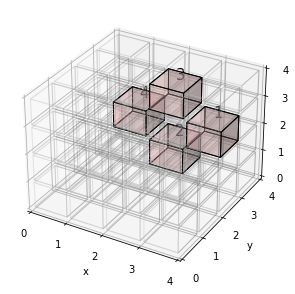

In [133]:
def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

regions = 4

# choose the colors (HTML RGBA code)
facecolors = np.where(voxelarray, '#FFCCCC55', '#FFFFFF00')
edgecolors = np.where(voxelarray, '#000000FF', '#E6E6E644')

filled = np.ones(voxelarray.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
ax.set_xlim(0,regions)
ax.set_ylim(0,regions)
ax.set_zlim(0,regions)
ax.set_xticks(np.arange(regions+1))
ax.set_yticks(np.arange(regions+1))
ax.set_zticks(np.arange(regions+1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)
# write numbers corresponding to the order of the diagonal elements from largest to smallest
for i in range(peak_meds.shape[0]):
    ax.text3D(hm_reg_x_sorted[i]+0.5, hm_reg_y_sorted[i]+0.5, hm_reg_z_sorted[i]+1, str(i+1), color='k', fontsize=15, alpha=1)


# ax.view_init(30, 60)
plt.savefig('3dsift-top-median.png')
plt.show()

# Draw all sub-regions

In [134]:
# utility function needed to draw all cuboids
def explode(data):
    size = np.array(data.shape)*2
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::2, ::2, ::2] = data
    return data_e

In [135]:
# draw all sub-regions a.k.a. cuboids
voxelarray = np.empty((4,4,4), dtype=bool) | True

# choose the colors
facecolors = np.where(voxelarray, '#99FFCC40', '#7A88CCC0')
edgecolors = np.where(voxelarray, '#00000040', '#7D84A6')

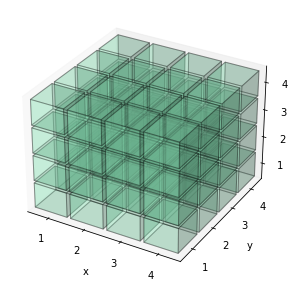

In [164]:
filled = np.ones(voxelarray.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

ax = plt.figure(figsize=(7,5)).add_subplot(projection='3d')
ax.grid(False)
ax.set_xlim(0,regions)
ax.set_ylim(0,regions)
ax.set_zlim(0,regions)
ax.set_xticks(np.arange(regions)+0.5, np.arange(regions)+1)
ax.set_yticks(np.arange(regions)+0.5, np.arange(regions)+1)
ax.set_zticks(np.arange(regions)+0.5, np.arange(regions)+1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)
# plt.subplots_adjust(bottom=0.15, left=1.5, right=2)
# ax.plot3D(2,2,2, marker='o', color='red', markersize=10)
# ax.view_init(30, 60)
plt.savefig('3dsift-all-subregions.png',dpi=300, bbox_inches = "tight")
plt.show()

# Highlight most informative regions

In [165]:
# draw cuboids where the top features are located
voxelarray = np.empty((4,4,4), dtype=bool) & False
x, y, z = np.indices((4,4,4))
for i in range(len(large_diag_sorted)):
    cube = ((z == region_z_sorted[i]) & (x == region_x_sorted[i]) & (y == region_y_sorted[i]))
    voxelarray = voxelarray | cube

In [166]:
# choose the colors (HTML RGBA code)
facecolors = np.where(voxelarray, '#FFCCCC55', '#FFFFFF00')
edgecolors = np.where(voxelarray, '#000000FF', '#E6E6E644')

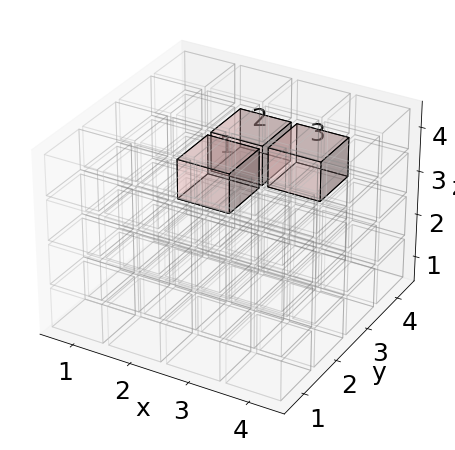

In [193]:
filled = np.ones(voxelarray.shape)

# upscale the above voxel image, leaving gaps
filled_2 = explode(filled)
fcolors_2 = explode(facecolors)
ecolors_2 = explode(edgecolors)

# Shrink the gaps
x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
x[0::2, :, :] += 0.05
y[:, 0::2, :] += 0.05
z[:, :, 0::2] += 0.05
x[1::2, :, :] += 0.95
y[:, 1::2, :] += 0.95
z[:, :, 1::2] += 0.95

ax = plt.figure(figsize=(11,8)).add_subplot(projection='3d')
ax.set_xlim(0,regions)
ax.set_ylim(0,regions)
ax.set_zlim(0,regions)
ax.set_xticks(np.arange(regions)+0.5, np.arange(regions)+1, fontsize=25)
ax.set_yticks(np.arange(regions)+0.5, np.arange(regions)+1, fontsize=25)
ax.set_zticks(np.arange(regions)+0.5, np.arange(regions)+1, fontsize=25)
ax.grid(False)
ax.set_xlabel('x', fontsize=25)
ax.set_ylabel('y', fontsize=25)
ax.set_zlabel('z', fontsize=25)
ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)
# write numbers corresponding to the order of the diagonal elements from largest to smallest
for i in range(len(large_diag_sorted)):
    ax.text3D(region_x_sorted[i]+0.5, region_y_sorted[i]+0.5, region_z_sorted[i]+1, str(i+1), color='k', fontsize=25, alpha=1)


# ax.view_init(30, 60)
plt.savefig('3dsift-top-diag.png',dpi=300, bbox_inches = "tight")
plt.show()

# Non-diagonal elements and orientation histograms

In [172]:
# find highly informative non-diagonal elements
large_x_nd_sorted = large_x_sorted[large_y_sorted != large_x_sorted]
large_y_nd_sorted = large_y_sorted[large_y_sorted != large_x_sorted]
large_nd_sorted = list(zip(large_x_nd_sorted, large_y_nd_sorted))
print('Largest non-diagonal elements:\n', large_nd_sorted)

# discard repeated entries
for pair in large_nd_sorted:
    if (pair[1], pair[0]) in large_nd_sorted:
        large_nd_sorted.remove(pair)
        
large_nd_sorted = np.array(large_nd_sorted)
print('Largest non-diagonal elements (without repeats):\n', large_nd_sorted)

Largest non-diagonal elements:
 [(277, 247), (247, 277), (270, 247), (247, 270)]
Largest non-diagonal elements (without repeats):
 [[247 277]
 [247 270]]


In [173]:
# find coordinates of large non-diagonal elements
nd_orient_sorted = large_nd_sorted%6 #6 is used instead of 12 because the feature vectors are subsampled
nd_region_x_sorted = large_nd_sorted//6%4
nd_region_y_sorted = large_nd_sorted//6//4%4
nd_region_z_sorted = large_nd_sorted//6//4//4
print('Highly informative features:\nreg_x: ', nd_region_x_sorted, '\nreg_y: ', nd_region_y_sorted, '\nreg_z: ', nd_region_z_sorted, '\nOrientation: ', nd_orient_sorted)

Highly informative features:
reg_x:  [[1 2]
 [1 1]] 
reg_y:  [[2 3]
 [2 3]] 
reg_z:  [[2 2]
 [2 2]] 
Orientation:  [[1 1]
 [1 0]]


In [229]:
# color_pallete = ['red', 'green', 'purple', 'brown', 'orange', 'pink', 'gray', 'olive', 'cyan']
# xx = np.arange(6)

# for j in range(4):
#     plt.figure(figsize=(10, 7))
#     plt.subplots_adjust(wspace=0.5)
#     for i in range(16):
#         plt.subplot(4,4,i+1)
#         # set colors
#         color = ['blue'] * 6
#         texts  = [''] * 6
#         for k in range(len(large_nd_sorted)):
#             if j==nd_region_z_sorted[k,0] and (i//4)==nd_region_y_sorted[k,0]  and (i%4)==nd_region_x_sorted[k,0]:
#                 color[nd_orient_sorted[k,0]] = color_pallete[k%len(color_pallete)]
#                 texts[nd_orient_sorted[k,0]]  = str(k+1)
#             if j==nd_region_z_sorted[k,1] and (i//4)==nd_region_y_sorted[k,1]  and (i%4)==nd_region_x_sorted[k,1]:
#                 color[nd_orient_sorted[k,1]] = color_pallete[k%len(color_pallete)]
#                 texts[nd_orient_sorted[k,1]]  = str(k+1)
        
#         plt.bar(xx, Mdiag[j*96+i*6:j*96+i*6+6], color=color, tick_label=texts)
#     plt.suptitle('Orientation Histograms (z = '+str(j)+')')
#     plt.savefig('3dsift-orient-hist-z'+str(j)+'.png',dpi=300, bbox_inches = "tight")

In [228]:
color_pallete = ['red', 'green', 'purple', 'brown', 'orange', 'pink', 'gray', 'olive', 'cyan']
xx = np.arange(6)
colors_list = []
texts_list = []

for j in range(4):
    for i in range(16):
        # set colors
        color = ['blue'] * 6
        texts  = [''] * 6
        for k in range(len(large_nd_sorted)):
            if j==nd_region_z_sorted[k,0] and (i//4)==nd_region_y_sorted[k,0]  and (i%4)==nd_region_x_sorted[k,0]:
                color[nd_orient_sorted[k,0]] = color_pallete[k%len(color_pallete)]
                texts[nd_orient_sorted[k,0]]  = str(k+1)
            if j==nd_region_z_sorted[k,1] and (i//4)==nd_region_y_sorted[k,1]  and (i%4)==nd_region_x_sorted[k,1]:
                color[nd_orient_sorted[k,1]] = color_pallete[k%len(color_pallete)]
                texts[nd_orient_sorted[k,1]]  = str(k+1)
        colors_list.append(color)
        texts_list.append(texts)

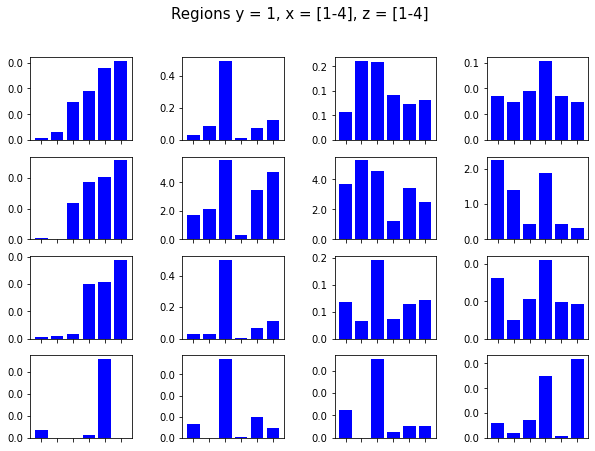

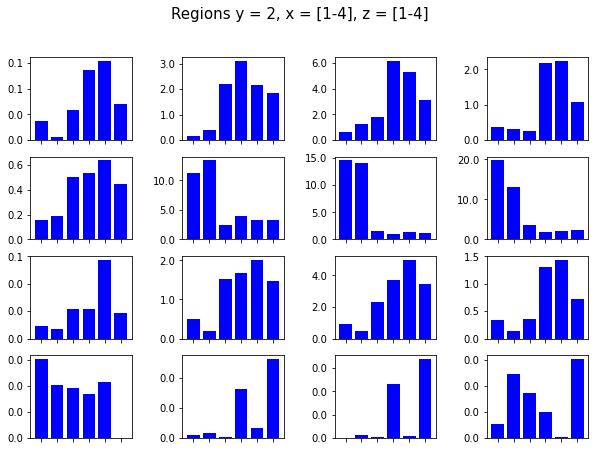

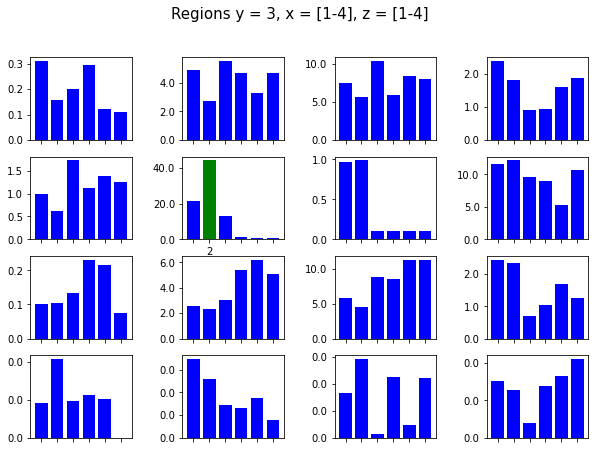

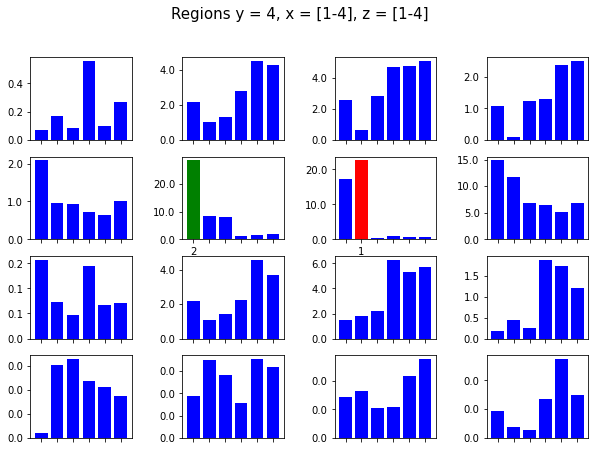

In [239]:
for y in range(4):
    plt.figure(figsize=(10, 7))
    # fig.tight_layout(rect=[0, 0.03, 1, 1])
    plt.subplots_adjust(wspace=0.5)
    for z in range(4):
        for x in range(4):
            ax = plt.subplot(4,4,(3-z)*4+x+1)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            plt.bar(xx, Mdiag[z*96+(y*4+x)*6:z*96+(y*4+x)*6+6], color=colors_list[z*16+y*4+x], tick_label=texts_list[z*16+y*4+x])
        
    plt.suptitle('Regions y = {}, x = [1-4], z = [1-4]'.format(y+1), fontsize=15)
    plt.savefig('3dsift-orient-hist-y'+str(y)+'.png',dpi=300, bbox_inches = "tight")

# Draw the icosahedron

In [175]:
# Golden ratio
gr = (1 + np.sqrt(5)) / 2

verts = [
          [0,  1,  gr], #0
          [0, -1,  gr], #1
          [0,  1, -gr], #2
          [0, -1, -gr], #3

          [ 1,  gr, 0], #4
          [-1,  gr, 0], #5
          [ 1, -gr, 0], #6
          [-1, -gr, 0], #7

          [ gr, 0,  1], #8
          [-gr, 0,  1], #9
          [ gr, 0, -1], #10
          [-gr, 0, -1], #11
        ]

faces = [
         [0, 1, 8],
         [0, 8, 4],
         [0, 4, 5],
         [0, 5, 9],
         [0, 9, 1],

         [1, 6, 8],
         [8, 6, 10],
         [8, 10, 4],
         [4, 10, 2],
         [4, 2, 5],

         [5, 2, 11],
         [5, 11, 9],
         [9, 11, 7],
         [9, 7, 1],
         [1, 7, 6],

         [3, 6, 7],
         [3, 7, 11],
         [3, 11, 2],
         [3, 2, 10],
         [3, 10, 6],
        ]


verts = np.array(verts)
faces = np.array(faces)
vert_colors = ['k'] * 12

# vert_colors[2] = 'r'

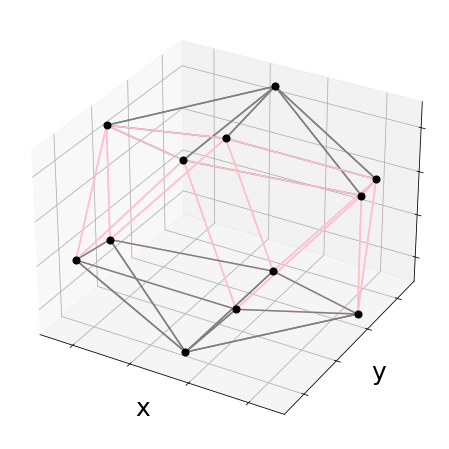

In [206]:
fig = plt.figure(figsize=(11,8))
ax = plt.axes(projection='3d')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_zlim(-1.5,1.5)
ax.set_xticks(np.linspace(-1.5,1.5,5)[:-1]+0.75/2, [])
ax.set_yticks(np.linspace(-1.5,1.5,5)[:-1]+0.75/2, [])
ax.set_zticks(np.linspace(-1.5,1.5,5)[:-1]+0.75/2, [])
ax.grid(True)
ax.set_xlabel('x', fontsize=25)
ax.set_ylabel('y', fontsize=25)
ax.set_zlabel('z', fontsize=25)

for i in range(12):
    ax.scatter3D(verts[i, 0], verts[i, 1], verts[i, 2], c=vert_colors[i], marker='o', s=50)
    # ax.text(verts[i, 0], verts[i, 1], verts[i, 2], '%s' % (str(i)), size=20, zorder=1,  color=vert_colors[i])
    
for face in faces[:5]:
    vertex0 = verts[face[0]]
    vertex1 = verts[face[1]]
    vertex2 = verts[face[2]]
    ax.plot([vertex0[0], vertex1[0]], [vertex0[1], vertex1[1]], [vertex0[2], vertex1[2]], color='gray')
    ax.plot([vertex0[0], vertex2[0]], [vertex0[1], vertex2[1]], [vertex0[2], vertex2[2]], color='gray')
    ax.plot([vertex1[0], vertex2[0]], [vertex1[1], vertex2[1]], [vertex1[2], vertex2[2]], color='gray')
    
for face in faces[5:15]:
    vertex0 = verts[face[0]]
    vertex1 = verts[face[1]]
    vertex2 = verts[face[2]]
    ax.plot([vertex0[0], vertex1[0]], [vertex0[1], vertex1[1]], [vertex0[2], vertex1[2]], color='pink')
    ax.plot([vertex0[0], vertex2[0]], [vertex0[1], vertex2[1]], [vertex0[2], vertex2[2]], color='pink')
    ax.plot([vertex1[0], vertex2[0]], [vertex1[1], vertex2[1]], [vertex1[2], vertex2[2]], color='pink')
    
for face in faces[15:20]:
    vertex0 = verts[face[0]]
    vertex1 = verts[face[1]]
    vertex2 = verts[face[2]]
    ax.plot([vertex0[0], vertex1[0]], [vertex0[1], vertex1[1]], [vertex0[2], vertex1[2]], color='gray')
    ax.plot([vertex0[0], vertex2[0]], [vertex0[1], vertex2[1]], [vertex0[2], vertex2[2]], color='gray')
    ax.plot([vertex1[0], vertex2[0]], [vertex1[1], vertex2[1]], [vertex1[2], vertex2[2]], color='gray')

# ax.view_init(30, 40)
plt.savefig('icosahedron.png',dpi=300, bbox_inches = "tight")

# Older code

## Visualize highly informative features

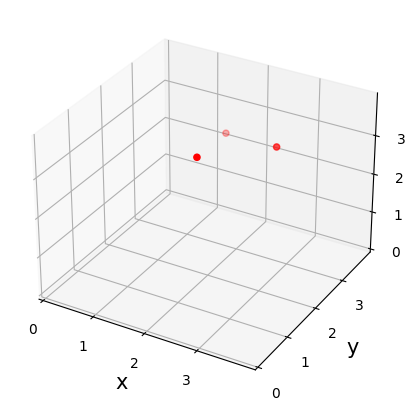

In [32]:
# draw the 64 sub-regions
regions = 4
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
ax.set_xlim(1,regions)
ax.set_ylim(1,regions)
ax.set_zlim(1,regions)
ax.set_xticks(np.arange(regions))
ax.set_yticks(np.arange(regions))
ax.set_zticks(np.arange(regions))
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.set_zlabel('z', fontsize=15)

# visualize a point in the region
ax.scatter3D(region_x_sorted+0.5, region_y_sorted+0.5, region_z_sorted+0.5, c='r')

In [33]:
# # prepare some coordinates
# x, y, z = np.indices((4, 4, 4))

# # draw cuboids
# voxelarray = np.empty(x.shape, dtype=bool) & False
# colors = np.empty(voxelarray.shape, dtype=object)
# for i in range(len(large_diag)):
#     cube = ((z == reg_y[i]) & (x == reg_z[i]) & (y == reg_x[i]))
#     voxelarray = voxelarray | cube
#     colors[cube] = 'red'

{(1, 2, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f0fcee8ddc0>,
 (1, 3, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f0fcdb8f970>,
 (2, 3, 2): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f0fcdb9d6a0>}

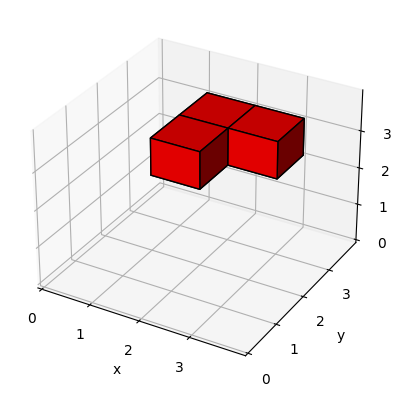

In [37]:
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(1,regions)
ax.set_ylim(1,regions)
ax.set_zlim(1,regions)
ax.set_xticks(np.arange(regions))
ax.set_yticks(np.arange(regions))
ax.set_zticks(np.arange(regions))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.voxels(voxelarray, facecolors='r', edgecolor='black')
# ax.text(1,1,1,s="test",color='red')
# plt.show()

<BarContainer object of 768 artists>

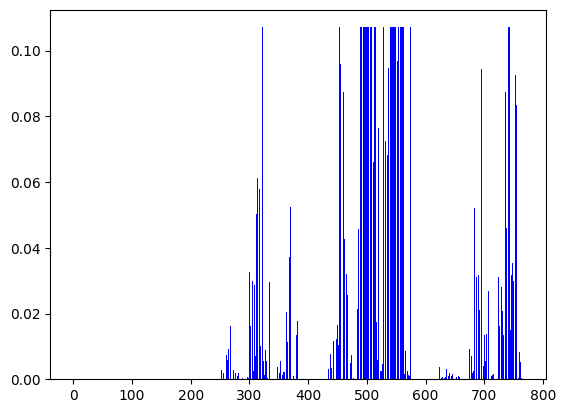

In [38]:
# draw a histogram of the discriptor's elements
xbar = np.arange(768)
plt.bar(xbar, desc, color='b')
desc1 = desc.copy()
desc1[xbar != large_x[0]] = 0
plt.bar(xbar, desc1, color='r', width=1)